In [2]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

In [38]:
df = pd.read_csv('Data/Auto.csv')
print(df.shape)
df.head()

(397, 9)


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [58]:
df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
year              int64
origin           object
name             object
high_mpg           bool
origin_JP       float64
origin_US       float64
dtype: object

In [78]:
isnumeric_horsepower = df["horsepower"].str.isnumeric()
(~isnumeric_horsepower).sum()

5

In [81]:
df = df.loc[isnumeric_horsepower, :]
df["horsepower"] = pd.to_numeric(df["horsepower"])
df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower        int64
weight            int64
acceleration    float64
year              int64
origin           object
name             object
high_mpg           bool
origin_JP       float64
origin_US       float64
dtype: object

In [82]:
df["high_mpg"] = df["mpg"] > df["mpg"].median()
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,high_mpg,origin_JP,origin_US
0,18.0,8,307.0,130,3504,12.0,70,US,chevrolet chevelle malibu,False,0.0,1.0
1,15.0,8,350.0,165,3693,11.5,70,US,buick skylark 320,False,0.0,1.0
2,18.0,8,318.0,150,3436,11.0,70,US,plymouth satellite,False,0.0,1.0
3,16.0,8,304.0,150,3433,12.0,70,US,amc rebel sst,False,0.0,1.0
4,17.0,8,302.0,140,3449,10.5,70,US,ford torino,False,0.0,1.0


`high_mpg` is the target for classification. </br>
Notes on the data:
 - origin: </br>
     Origin of car (1. American, 2. European, 3. Japanese)

Clearly, ordinal encoding is unsuitable for it.

In [40]:
from sklearn.preprocessing import OneHotEncoder

df["origin"].replace({1: "US", 2: "EU", 3: "JP"}, inplace=True)
enc = OneHotEncoder(drop="first").fit(df[["origin"]])
enc_origin = pd.DataFrame(
    enc.transform(df[["origin"]]).toarray(),
    columns=enc.get_feature_names_out(["origin"]),
    index=df.index
)
df = pd.concat([
    df,
    enc_origin,
], axis=1)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,high_mpg,origin_JP,origin_US
0,18.0,8,307.0,130,3504,12.0,70,US,chevrolet chevelle malibu,False,0.0,1.0
1,15.0,8,350.0,165,3693,11.5,70,US,buick skylark 320,False,0.0,1.0
2,18.0,8,318.0,150,3436,11.0,70,US,plymouth satellite,False,0.0,1.0
3,16.0,8,304.0,150,3433,12.0,70,US,amc rebel sst,False,0.0,1.0
4,17.0,8,302.0,140,3449,10.5,70,US,ford torino,False,0.0,1.0


/home/lev/.local/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 16.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


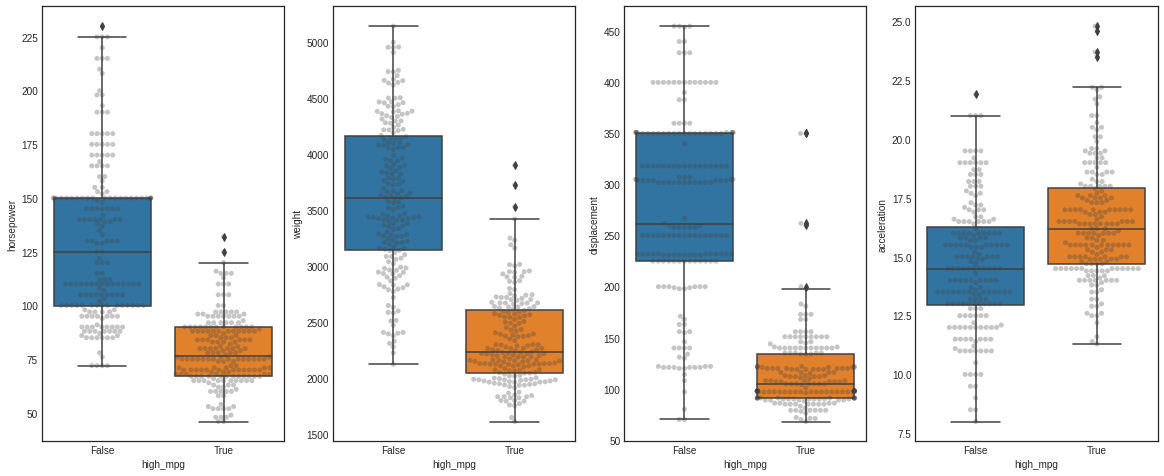

In [101]:
f, axs = plt.subplots(1, 4, figsize=(20, 8))


for ax, y in zip(axs, ["horsepower", "weight", "displacement", "acceleration"]):
    sns.swarmplot(x="high_mpg", y=y, data=df, ax=ax, color=".25", alpha=0.3)
    sns.boxplot(x="high_mpg", y=y, data=df, ax=ax)


In [48]:
f, axs = plt.subplots(1, 4, figsize=(20, 8))


for ax, y in zip(axs, ["horsepower", "weight", "displacement", "acceleration"]):
    sns.swarmplot(x="high_mpg", y=y, data=df, ax=ax, color=".25", alpha=0.3)
    sns.boxplot(x="high_mpg", y=y, data=df, ax=ax)

0

In [103]:
df["year"].value_counts()

73    40
78    36
76    34
75    30
82    30
70    29
79    29
72    28
77    28
81    28
71    27
80    27
74    26
Name: year, dtype: int64

Text(0.5, 0.98, "Year's relation to mpg")

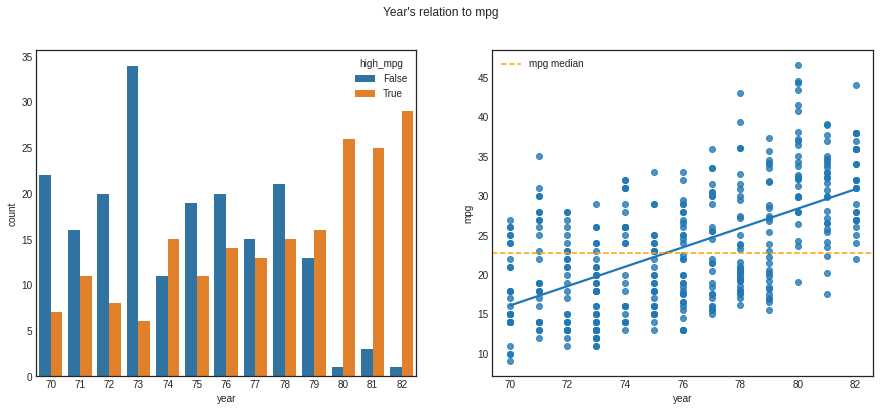

In [138]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.countplot(x="year", hue="high_mpg", data=df, ax=ax1)
sns.regplot(x="year", y="mpg", data=df, ci=False, ax=ax2)
ax2.axhline(df["mpg"].median(), ls='--', color="orange", label="mpg median")
ax2.legend()
f.suptitle("Year's relation to mpg")

<AxesSubplot:xlabel='cylinders', ylabel='count'>

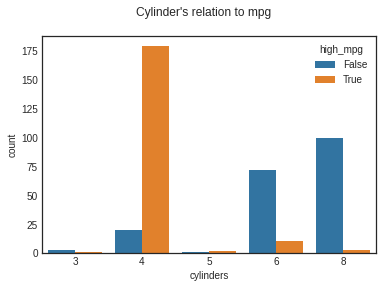

In [139]:
plt.gcf().suptitle("Cylinder's relation to mpg")
sns.countplot(x="cylinders", hue="high_mpg", data=df)

<AxesSubplot:>

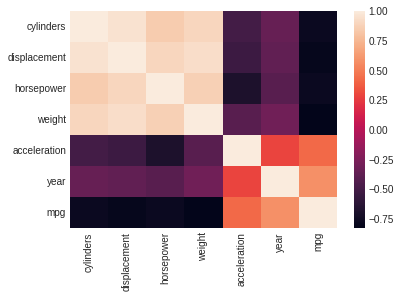

In [145]:
sns.heatmap(
    df[
        ["cylinders", "displacement", "horsepower", 
         "weight", "acceleration", "year", "mpg"]
    ].corr(),
    data=df
)

Observations: each variable is important, high collinearity between the predictors, especially in the upper-left corner


In [177]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

def plot_cm(y_true, y_pred, title=""):
    f, axs = plt.subplots(1, 2, figsize=(10, 4))

    for ax, normalize in zip(axs, ["true", "pred"]):
        ConfusionMatrixDisplay.from_predictions(
            y_true, y_pred,
            cmap=plt.cm.Blues, 
            normalize=normalize,
            ax=ax
        )
        ax.set_title("Normalized along: " + normalize)
    f.suptitle(title, fontsize=16)

In [149]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=["origin", "mpg", "high_mpg", "name"]),
    df["high_mpg"],
    random_state=42,
    test_size=0.2
)

              precision    recall  f1-score   support

       False       1.00      0.74      0.85        42
        True       0.77      1.00      0.87        37

    accuracy                           0.86        79
   macro avg       0.89      0.87      0.86        79
weighted avg       0.89      0.86      0.86        79



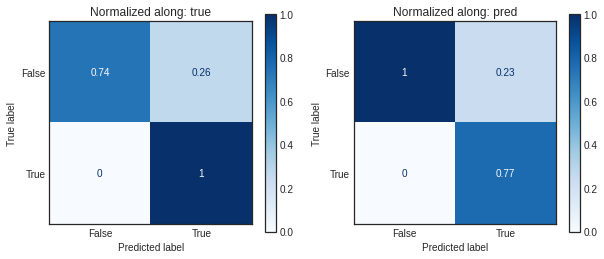

In [179]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA().fit(X_train, y_train)
plot_cm(y_test, lda.predict(X_test))
print(classification_report(y_test, lda.predict(X_test)))

In [173]:
from sklearn.linear_model import LinearRegression

y_regr = df.loc[X_train.index, "mpg"]
lmod = LinearRegression().fit(X_train, y_regr)
lmod.score(X_train, y_regr)

0.8286865575852228

In [181]:
regr_pred = lmod.predict(X_test)
regr_pred = np.array(list(map(lambda x: x > df["mpg"].median(), regr_pred)))
regr_pred[:10]

array([ True,  True,  True,  True,  True,  True, False,  True, False,
        True])

              precision    recall  f1-score   support

       False       1.00      0.76      0.86        42
        True       0.79      1.00      0.88        37

    accuracy                           0.87        79
   macro avg       0.89      0.88      0.87        79
weighted avg       0.90      0.87      0.87        79



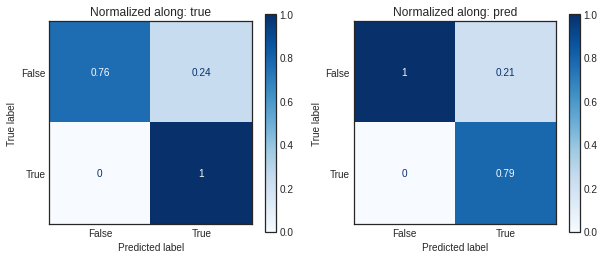

In [182]:
plot_cm(y_test, regr_pred)
print(classification_report(y_test, regr_pred))

The resulting classification strategies are essentially the same in terms of performance.

In [188]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import GaussianNB

classifiers = [
    QDA().fit(X_train, y_train), 
    # best performance value is chosen
    KNN(3).fit(X_train, y_train), 
    GaussianNB().fit(X_train, y_train)
]

QuadraticDiscriminantAnalysis 
               precision    recall  f1-score   support

       False       1.00      0.79      0.88        42
        True       0.80      1.00      0.89        37

    accuracy                           0.89        79
   macro avg       0.90      0.89      0.89        79
weighted avg       0.91      0.89      0.89        79

KNeighborsClassifier 
               precision    recall  f1-score   support

       False       1.00      0.86      0.92        42
        True       0.86      1.00      0.92        37

    accuracy                           0.92        79
   macro avg       0.93      0.93      0.92        79
weighted avg       0.93      0.92      0.92        79

GaussianNB 
               precision    recall  f1-score   support

       False       0.97      0.79      0.87        42
        True       0.80      0.97      0.88        37

    accuracy                           0.87        79
   macro avg       0.89      0.88      0.87        79
weight

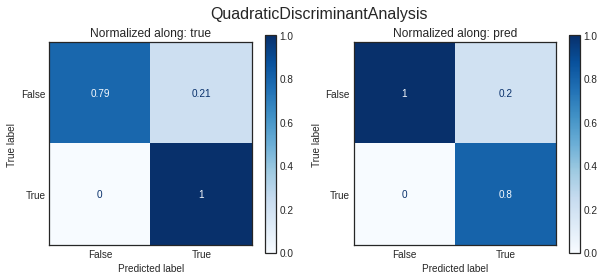

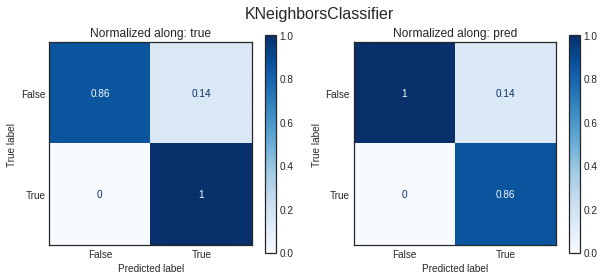

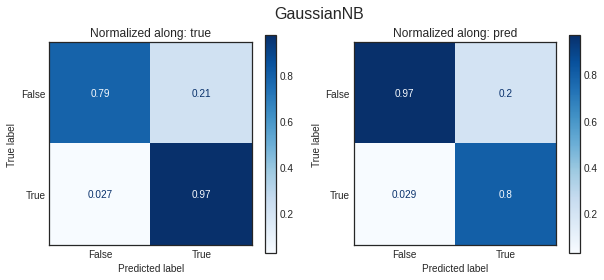

In [189]:
for clf in classifiers:
    plot_cm(y_test, clf.predict(X_test), title=clf.__class__.__name__)
    print(
        clf.__class__.__name__,'\n', 
        classification_report(y_test, clf.predict(X_test))
    )

The best one overall in terms of accuracy is `KNN(3)`